#### RETAIL ANALYSIS 

1. ##### Data Pre-processing
2. ##### RFM Analysis
3. ##### Market Segmentation
4. ##### Market Basket Analysis
4. ##### Conclusion

In [4]:
#Imports
#Data cleaning 
import pandas as pd
from ast import literal_eval
from datetime import datetime as dt
from numpy import where

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
sns.set(style='white')

import plotly.graph_objects as go

In [5]:
#READ DATA
#users= read_csv('../input/awssampleretaildemostore/users.csv')
users = pd.read_csv(r'.\Input\raw_users.csv', usecols =[0,1,2,3,4,5,6,7])
#items = read_csv('../input/awssampleretaildemostore/items.csv')
products = pd.read_csv(r'.\Input\raw_products.csv', 
                       usecols = [0,3,4,5,7,10])
df_lst = pd.read_csv(r'.\Input\interactions.csv',
                        iterator=True, chunksize=20000)

df = pd.concat(df_lst)    

## Data Cleaning and Exploration

In [6]:

users.columns = [c.lower() for c in users.columns]

# Parse address information
add_lst = ['address1', 'country', 'city', 'state', 'zipcode']
users.addresses = users.addresses.apply(lambda x: [(literal_eval(x[1:-1])).\
                                                   get(i) for i in add_lst])
users[add_lst] = pd.DataFrame(users.addresses.tolist())
users.drop('addresses', axis=1, inplace = True)
users.head()

,id,username,email,first_name,last_name,age,gender,address1,country,city,state,zipcode
0,1,user1,mark.johnson@example.com,Mark,Johnson,31,M,51161 Maurice Fort,US,South Davidside,HI,96721
1,2,user2,kristen.calderon@example.com,Kristen,Calderon,58,F,871 Callahan Dale,US,New Candacebury,TX,79337
2,3,user3,joseph.maddox@example.com,Joseph,Maddox,43,M,03911 Cabrera Wall Suite 227,US,Martinmouth,AL,36246
3,4,user4,jay.lewis@example.com,Jay,Lewis,38,M,9973 Aguirre Expressway,US,South Rodneyview,OR,97747
4,5,user5,anthony.valdez@example.com,Anthony,Valdez,24,M,60260 Baker Spurs,US,West Susan,AR,72739


In [7]:
# Clean Interaction data

#Convert timestamp
df.columns = [c.lower() for c in df.columns]
df['date'] = pd.to_datetime(df['timestamp'],  unit='s')
df.drop('timestamp', axis = 1, inplace = True)

#Check for duplicates
df.drop_duplicates(inplace = True)


In [8]:
products.rename(columns={'id': 'item_id', 'name': 'product_name'}, 
               inplace = True)

#Merge all datasets
df = df.merge(products, how='left').merge(
                                    users, how='left', left_on = 'user_id',
                                    right_on = 'id')
df.drop('id', axis = 1, inplace = True) 

### Missing data 
After the merge all fields have no missing data, in the *price* field this is intuitively not correct as some *event_type* should not have a price i.e *productViewed*. Thus set *order_completed* *event_type* to have price.

In [9]:
missing_value = df.isnull().sum()
#No missing values

In [10]:
#Remove price from non purchasing event_types
browse = ['ProductViewed', 'ProductAdded', 'CartViewed', 'CheckoutStarted']
df['price'] = where(df['event_type'].isin(browse), "", df['price'])
df['price'] = pd.to_numeric(df['price'])

## Products Categories Analysis
&emsp;  **Orders, Revenue, By Categories** <br>
1.  Which are the largest product categories by order numbers, revenue, and number of products sold?<br>
2.  How do the categories compare in terms of interactions and also conversion rates?<br>
3. Which are the top and bottom 10 performing products in terms of revenue?<br>
4. What is the average revenue per order by product categories? <br>

In [11]:
#How many Categories 
df_categories = df[~df['price'].isna()].groupby('category').agg(
                                       no_of_customers = ('user_id','nunique'),
                                       no_of_products = ('product_name', 'nunique'),
                                       revenue_by_category=('price', 'sum'),
                                       no_orders = ('price', 'count')
                                      ).reset_index()
df_categories['average_revenue_per_order'] = (df_categories['revenue_by_category']/
                                              df_categories['no_orders']).round(2)
df_categories

,category,no_of_customers,no_of_products,revenue_by_category,no_orders,average_revenue_per_order
0,accessories,415,112,55494.44,556,99.81
1,apparel,448,145,70265.96,607,115.76
2,beauty,143,44,6883.05,161,42.75
3,books,77,21,1907.21,79,24.14
4,electronics,204,23,80597.69,237,340.07
5,floral,255,14,30932.88,312,99.14
6,footwear,352,86,26296.53,447,58.83
7,furniture,427,124,179716.13,589,305.12
8,groceries,360,77,4349.39,461,9.43
9,homedecor,386,50,25318.09,494,51.25


In [12]:
print(f'There are {df_categories.no_of_customers.sum()} unique customers.')
print(f'There are {df_categories.no_of_products.sum()} unique products sold.')
print(f'A total of {"${:,.2f}".format(df_categories.revenue_by_category.sum())} revenue was generated.')
print(f'{df_categories.no_orders.sum()} orders were fulfilled.')


There are 4611 unique customers.
There are 897 unique products sold.
A total of $680,598.65 revenue was generated.
5819 orders were fulfilled.


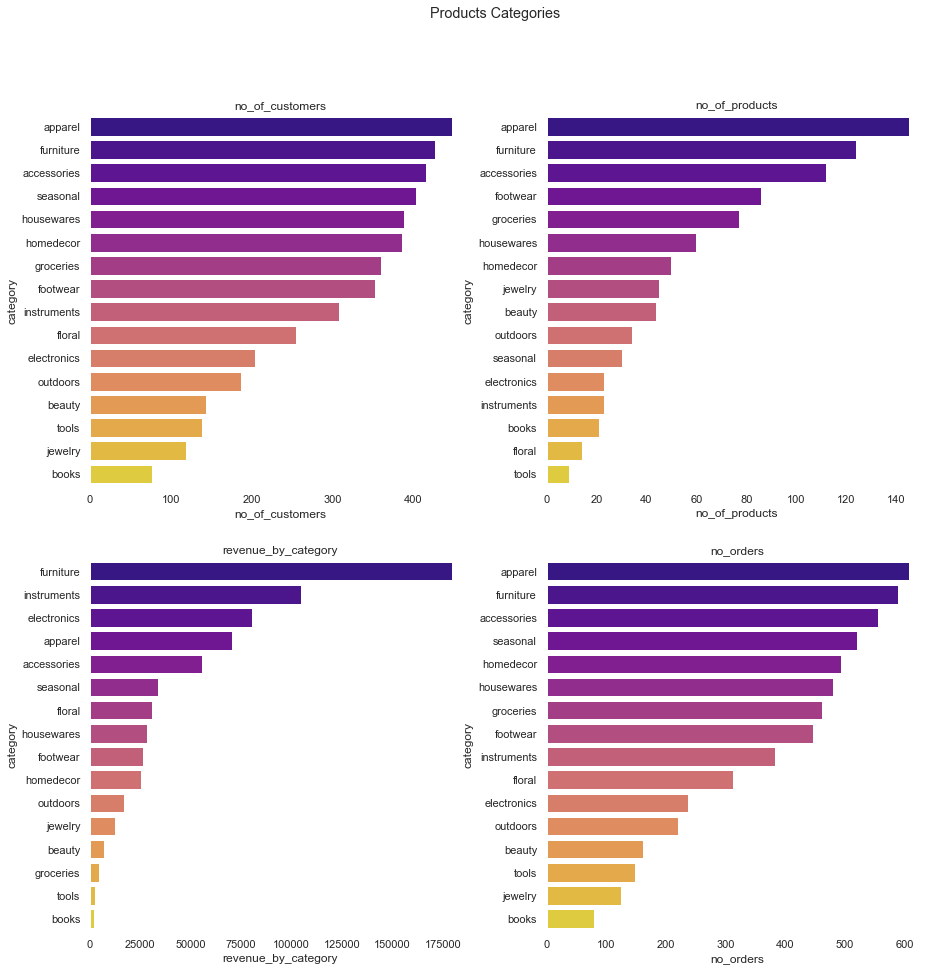

In [13]:
figure, axis = plt.subplots(2, 2,figsize=(15, 15), facecolor='w', edgecolor='k')

a = 2 #rows
b = 2 # columns
c = 1 # subplot iterator

for i in df_categories.columns[1:-1]:
    plt.subplot(a, b, c)
    plt.title(f'{i}')
    plt.xlabel(i)
    plt.suptitle('Products Categories')
    plt.ylabel('')
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.barplot(x = i, y = 'category', data = df_categories,
                order= df_categories.sort_values(
                    by=[i], ascending=False).set_index('category').index,
               palette = 'plasma')
    sns.despine(bottom = True, left = True)
    c = c + 1

plt.show()

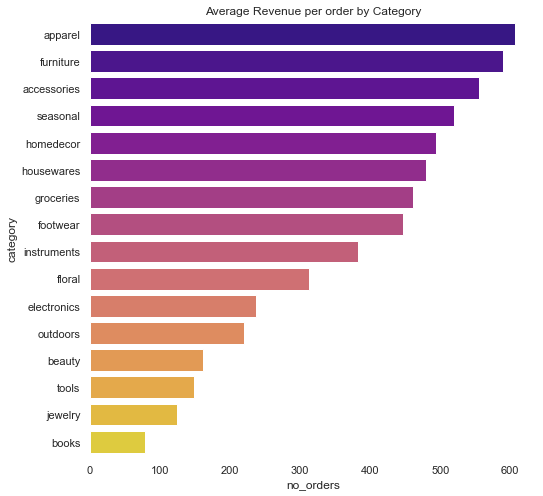

In [14]:
#High ticket categories

plt.figure(figsize=(8,8))
sns.barplot(x = i, y = 'category', data = df_categories,
                order= df_categories.sort_values(
                    by=[i], ascending=False).set_index('category').index,
               palette = 'plasma')
plt.title('Average Revenue per order by Category')

sns.despine(bottom = True, left = True)

*Furniture*, *apparels*, *instruments* and *electronic* are the top categories by total revenue. Likely correlation between number of products per category and number of orders completed.
In addition *apparel*, *furniture*, *accessories* and *seasonal* categories have highest average revenue per order.

## Products
1. which product have the  highest number of orders? <br>
2. Highest and lowest revenue products

In [15]:
df_products = (df[~df['price'].isna()].groupby('product_name').agg(orders = ('user_id', 'nunique'),
                              revenue_by_product = ('price', 'sum')
                                                   ).reset_index()
                 .sort_values(by=['revenue_by_product'], ascending = False))

df_products.iloc[:10]

,product_name,orders,revenue_by_product
826,Video Camera,47,33494.50
105,Camera,36,25231.63
285,Electric Guitar,60,20651.33
7,Acoustic Drum,56,15440.41
244,Dark Slate Gray Sofa,11,10125.87
432,Keyboard,30,9831.67
375,Gray Sofa,10,9682.89
545,Pale Gray Sofa,12,8656.88
6,Acoustic Bass,25,8432.73
669,Sienna Sofa,11,8352.89


&emsp; **interactions by category**
1. What is the overall conversion rate for the store? <br>
2. What are the conversion raates for each product categories? <br>
3. Analyze customer flow. <br>

In [16]:
df_interactions = df[['user_id', 'event_type', 'category']]
df_interactions =(df_interactions.pivot_table(index=['category'],
                                    values = 'user_id',
                                    columns='event_type', aggfunc= 'count')
                                    .reset_index().rename_axis("", axis=1)
                                     )

inter_seq = ['category','ProductViewed','ProductAdded', 'CartViewed', 'CheckoutStarted',
             'OrderCompleted']

interactions = df_interactions[inter_seq].copy()
interactions['TotalInteractions'] = (interactions[interactions.columns[1:]].apply(
                                                lambda x: sum(x), axis = 1))
interactions.sort_values(by ='TotalInteractions', ascending=False, inplace=True)
interactions

,category,ProductViewed,ProductAdded,CartViewed,CheckoutStarted,OrderCompleted,TotalInteractions
10,housewares,38559,3779,2311,967,480,46096
1,apparel,28547,4722,2861,1203,607,37940
0,accessories,26276,4351,2802,1078,556,35063
7,furniture,24535,4688,2972,1161,589,33945
9,homedecor,25421,3889,2451,953,494,33208
14,seasonal,23896,4360,2755,1062,520,32593
11,instruments,25930,3000,1893,752,383,31958
8,groceries,23842,3935,2462,932,461,31632
6,footwear,22518,3753,2359,934,447,30011
5,floral,19394,2403,1501,625,312,24235


In [17]:
#Conversion Absolute heatmap
df_i = (df_interactions.set_index('category')[inter_seq[1:]]
        .sort_values(by=['ProductViewed']))
plt.figure(figsize=(6,5))

fig = go.Figure(data =
     go.Heatmap(x = df_i.columns, y = df_i.index.values,
                z = df_i.values,
               colorscale = 'plasma_r'))

fig.update_xaxes(side="top")
fig.show()

<Figure size 432x360 with 0 Axes>

In [18]:
transition_rates = interactions[interactions.columns[:-1]].copy()

def trans_rate(f, t):
    rate = (transition_rates[t]*100/transition_rates[f]).round(2)
    return rate

actions = ['ProductViewed', "ProductAdded", 'CartViewed','CheckoutStarted', 'OrderCompleted']
rate_lst = [trans_rate(actions[i],actions[i+1]) for i in range(len(actions)-1)]

trans_matrix = pd.DataFrame(zip(*rate_lst), index=transition_rates.category,
                           columns= actions[1:])

trans_matrix = trans_matrix.sort_values(by='ProductAdded')

#Conversion percent heatmap
plt.figure(figsize=(6,5))
fig = go.Figure(data =
     go.Heatmap(x = trans_matrix.columns, y = trans_matrix.index.values,
                z = trans_matrix.values,
               colorscale = 'plasma_r'))

fig.update_xaxes(side="top")
fig.show()
#rate_lst

<Figure size 432x360 with 0 Axes>

In [19]:
#Calculate conversion rate
interactions['Conversion_rate'] = (interactions['OrderCompleted'] *100/
                                      interactions['TotalInteractions']).round(3)
interactions

,category,ProductViewed,ProductAdded,CartViewed,CheckoutStarted,OrderCompleted,TotalInteractions,Conversion_rate
10,housewares,38559,3779,2311,967,480,46096,1.041
1,apparel,28547,4722,2861,1203,607,37940,1.600
0,accessories,26276,4351,2802,1078,556,35063,1.586
7,furniture,24535,4688,2972,1161,589,33945,1.735
9,homedecor,25421,3889,2451,953,494,33208,1.488
14,seasonal,23896,4360,2755,1062,520,32593,1.595
11,instruments,25930,3000,1893,752,383,31958,1.198
8,groceries,23842,3935,2462,932,461,31632,1.457
6,footwear,22518,3753,2359,934,447,30011,1.489
5,floral,19394,2403,1501,625,312,24235,1.287


In [20]:
print(f'The overall conversion rate is:\
       {"{:.3f}%".format(interactions.Conversion_rate.mean())}')

The overall conversion rate is:       1.409%


All product categories have a conversion rate in range 1.0 - 1.7% with *books* and *housewares* having the highest and lowest respectively.

In [29]:
categories =df_i.index.values.tolist()
category_plot_names = []
fig = go.Figure()

buttons=[]

default_category = "apparel"

for cat in categories:
    x = sorted(df_i.loc[cat].values.tolist(), reverse=True)
    #print(x)
    fig.add_traces(go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['ProductViewed', "ProductAdded", 'CartViewed','Checkout', 'Sale' ],
      color = ["blue", "red", "yellow", "green", "purple", "cyan", "black"] 
    ),
    link = dict(
      source = [0, 1, 2, 3, 4],
      target = [1, 2, 3, 4],
      value = x
    ), 
    visible=(cat==default_category)
    ))
    
    category_plot_names.append(cat)
    
for cat in categories:
    buttons.append(dict(method='update',
                        label=cat,
                        args = [{'visible': [cat==r for r in category_plot_names]}])) 
    
# Add dropdown menus to the figure
fig.update_layout(showlegend=False, updatemenus=[{"buttons": buttons, "direction": "down",
                                                  "active": categories.index(default_category),
                                                  "showactive": True, "x": 1, "y": 1.05}])
fig.show()
fig.write_html('Sales funnel.html', auto_open=True)


## Time

In [22]:
df['date'].dt.month.unique()
#This is 3 Months of data june/july/ August

df['month'] = df['date'].dt.month_name()

df['hod'] = [r.hour for r in df.date]
df['day_of_year'] = df['date'].dt.strftime('%j')
df['day_of_week'] = df['date'].dt.strftime('%a')
              

In [23]:
df_t = df.groupby('month').agg(no_of_customers = ('user_id','nunique'),
                           no_of_products = ('product_name', 'nunique'),
                           revenue_by_category=('price', 'sum'),
                           no_orders = ('price', 'count')
                          ).reset_index()
#Reorder by Month
sort_order= ['June', 'July', 'August'] #category order
df_t.index = pd.CategoricalIndex(df_t['month'], categories=sort_order, ordered=True)
df_t = df_t.sort_index().reset_index(drop = True)   
df_t['revenue change %'] = ((df_t['revenue_by_category'] - df_t['revenue_by_category'].shift(1))*100/
                            df_t['revenue_by_category']).round(2)
df_t                        

,month,no_of_customers,no_of_products,revenue_by_category,no_orders,revenue change %
0,June,6000,952,184200.21,1598,NaN
1,July,6000,952,284452.06,2434,35.24
2,August,6000,952,211946.38,1787,-34.21


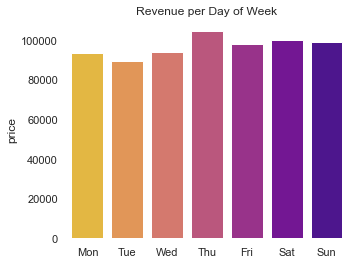

In [24]:
#What is the distribution of sales over time(day of week)?
revenue_by_day = pd.DataFrame(df.groupby('day_of_week', as_index= True)['price'].sum())
cats = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
revenue_by_day.index = pd.Categorical(revenue_by_day.index, categories= cats, ordered=True)
revenue_by_day = revenue_by_day.sort_index()

plt.figure(figsize=(5,4))
sns.barplot(y = 'price', x = revenue_by_day.index, data = revenue_by_day,  
               palette = 'plasma_r')
plt.title('Revenue per Day of Week')

sns.despine(bottom = True, left = True)

Revenue/sales per day of week are uniformly distributed.

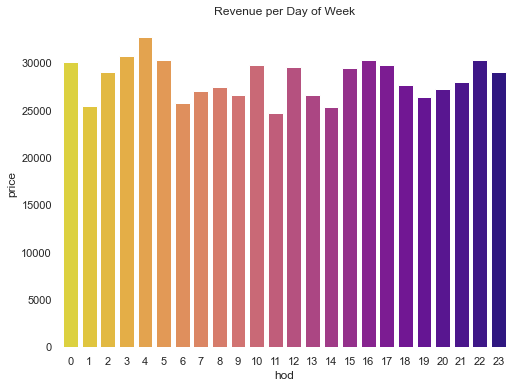

In [25]:
plt.figure(figsize=(8,6))
revenue_by_hod = pd.DataFrame(df.groupby('hod', as_index= True)['price'].sum())
sns.barplot(y = 'price', x = revenue_by_hod.index, data = revenue_by_hod,  
               palette = 'plasma_r')
plt.title('Revenue per Day of Week')

sns.despine(bottom = True, left = True)

## Sales by Geography

In [26]:
df.state.nunique()

51

In [27]:
df_geo = df[~df['price'].isna()].groupby('state').agg(orders = ('user_id', 'nunique'),
                              revenue_by_state = ('price', 'sum')
                                                   ).reset_index()

In [28]:
fig = go.Figure(data=go.Choropleth(
    locations=df_geo['state'], # Spatial coordinates
    z = df_geo['revenue_by_state'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'viridis_r',
    colorbar_title = "Revenue USD",
))

fig.update_layout(
    title_text = 'June - August Revenue by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()